In [1]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23680 23680
Found 23680 images belonging to 1 classes.
Found 23680 images belonging to 1 classes.


In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.32109958 0.33710063]
(80, 120, 3) [0.         0.         1.         1.         0.04433761 0.17564103]
ipykernel_launcher:14: RuntimeWarning: Mean of empty slice.
/home/aiffel-dj2/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ipykernel_launcher:15: RuntimeWarning: Mean of empty slice.


In [5]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 25,669,126
Trainable params: 2,104,326
Non-trainable params: 23,564,800
_________________________________________________________________


In [6]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [7]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [8]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 20160 32 630 -> 데이터를 batch_size 의 배수로 준비해 주세요.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23680 32 740
Epoch 1/20
ipykernel_launcher:14: RuntimeWarning: Mean of empty slice.
ipykernel_launcher:15: RuntimeWarning: Mean of empty slice.
740/740 [==============================] - 23s 31ms/step - loss: 0.0204 - mae: 0.0670
Epoch 2/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0127 - mae: 0.0521
Epoch 3/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0125 - mae: 0.0516
Epoch 4/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0124 - mae: 0.0513
Epoch 5/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0124 - mae: 0.0511
Epoch 6/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0124 - mae: 0.0510
Epoch 7/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0124 - mae: 0.0509
Epoch 8/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0124 - mae: 0.0509
Epoch 9/20
740/740 [==============================] - 17s 23ms/step - loss: 0.0123 - mae: 0

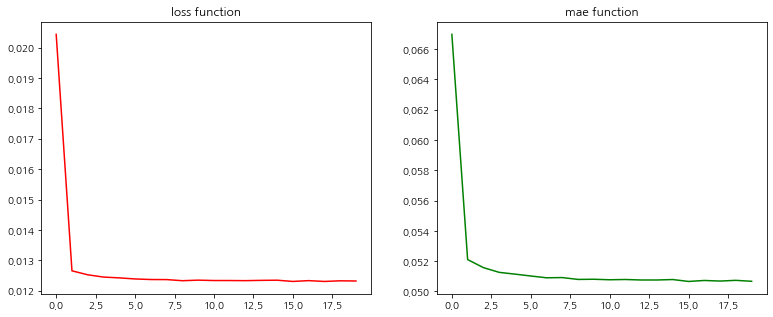

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].plot(history.history['loss'], 'r')
axs[0].set_title('loss function')

axs[1].plot(history.history['mae'], 'g')
axs[1].set_title('mae function')
plt.show()

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2636 images belonging to 1 classes.
Found 2636 images belonging to 1 classes.


In [11]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Instructions for updating:
Please use Model.evaluate, which supports generators.
ipykernel_launcher:14: RuntimeWarning: Mean of empty slice.
ipykernel_launcher:15: RuntimeWarning: Mean of empty slice.
0.011881296522915363 0.04952935874462128


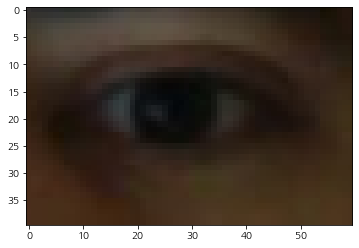

In [12]:
# img test
test_dir = os.getenv('HOME')+'/aiffel/coarse_to_fine'
img = cv2.imread(test_dir + '/data/eye.png')

img = cv2.resize(img, (60, 40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[3.6094310e-03 1.3985699e-03]
  [1.1999305e+02 7.9994804e+01]
  [5.3470718e+01 2.7235987e+01]]]


[0. 0.]
[60. 40.]
[26.5 13.5]


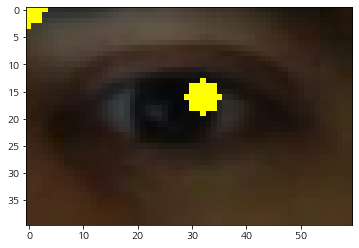

In [14]:
show = img.copy()
for pt in repred[0]:
    show = cv2.circle(show, tuple((pt*0.6).astype(int)), 3, (0,255,255), -1)
    print (pt.round()*0.5)
    
plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

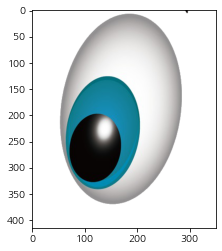

In [22]:
test_dirs = os.getenv('HOME')+'/Downloads/data'
right = cv2.imread(test_dirs + '/test1.png')
cropped_img = right[170: 1000, 300: 1000]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
x = int(repred[0][2][0].round()*0.6)
y = int(repred[0][2][1].round()*0.6)
w = 30
h = 30
print ('(x,y) : (%d,%d)'%(x,y))
print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (31,16)
(w,h) : (30,30)


In [24]:
img_sticker = cv2.resize(cropped_img, (w,h))
print (img_sticker.shape)

(30, 30, 3)


In [25]:
refined_x = x - w // 2  # left
refined_y = y - h // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (16,1)


In [26]:
img_sticker = img_sticker[refined_y:]
print (img_sticker.shape)

(29, 30, 3)


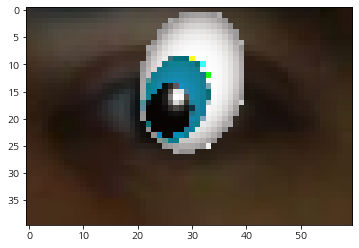

In [27]:
sticker_area = show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()